In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score,classification_report

from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

Read the dataset

In [100]:
path = '../Dataset/bank_customer.csv'
df = pd.read_csv(path)

In [101]:
df.head()

,Unnamed: 0,ID,Gender,Month_Income,Age,Region_Code,Occupation,Credit_Score,Loan_Status,Existing_Credit_Cards,Avg_Account_Balance,Account_Category,Tenure_with_Bank,Lead_Outcome
0,0,VBENBARO,Male,96345.0,29,254,Other,623,Yes,4,742366,X1,2,No
1,1,CCMEWNKY,Male,85640.0,43,268,Other,629,NaN,0,925537,X2,1,No
2,2,VK3KGA9M,Male,96345.0,31,270,Salaried,357,No,0,215949,X1,1,No
3,3,TT8RPZVC,Male,85640.0,29,272,Other,356,No,0,868070,X1,3,No
4,4,SHQZEYTZ,Female,42820.0,29,270,Other,572,No,0,657087,X1,3,No


In [102]:
#mapping the Account_Category	
category_mapping = {
    'X1': 'Savings Account',
    'X2': 'Current Account',
    'X3': 'Senior Citizens Account',
    'X4': 'Investment Account'
}

# Replace the values in the Account_Category column
df['Account_Category'] = df['Account_Category'].replace(category_mapping)

Data Gathering and Exploration

In [103]:
df.duplicated().sum()

0

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105000 entries, 0 to 104999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             105000 non-null  int64  
 1   ID                     105000 non-null  object 
 2   Gender                 105000 non-null  object 
 3   Month_Income           102514 non-null  float64
 4   Age                    105000 non-null  int64  
 5   Region_Code            105000 non-null  int64  
 6   Occupation             102486 non-null  object 
 7   Credit_Score           105000 non-null  int64  
 8   Loan_Status            92511 non-null   object 
 9   Existing_Credit_Cards  105000 non-null  int64  
 10  Avg_Account_Balance    105000 non-null  int64  
 11  Account_Category       105000 non-null  object 
 12  Tenure_with_Bank       105000 non-null  int64  
 13  Lead_Outcome           105000 non-null  object 
dtypes: float64(1), int64(7), object(6)
m

In [105]:
missing_values = df.isna().sum().to_dict()

# Filter columns with missing values
columns_with_missing_values = {k: v for k, v in missing_values.items() if v > 0}

column_data_types = df.dtypes.to_dict()

numerical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] in ['int64', 'float64']}
categorical_missing = {k: v for k, v in columns_with_missing_values.items() if column_data_types[k] == 'object'}

print("Numerical columns with missing values:", numerical_missing)
print("Categorical columns with missing values:", categorical_missing)

Numerical columns with missing values: {'Month_Income': 2486}
Categorical columns with missing values: {'Occupation': 2514, 'Loan_Status': 12489}


Fill the missing values in the columns

In [106]:
# for column in categorical_missing:
#     if df[column].isnull().any():
#         df[column] = df[column].fillna(df[column].mode()[0])

In [107]:
# for column in numerical_missing:
#     if df[column].isnull().any():
#         df[column] = df[column].fillna(df[column].mean())

In [108]:
df = df.dropna()

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88143 entries, 0 to 104998
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             88143 non-null  int64  
 1   ID                     88143 non-null  object 
 2   Gender                 88143 non-null  object 
 3   Month_Income           88143 non-null  float64
 4   Age                    88143 non-null  int64  
 5   Region_Code            88143 non-null  int64  
 6   Occupation             88143 non-null  object 
 7   Credit_Score           88143 non-null  int64  
 8   Loan_Status            88143 non-null  object 
 9   Existing_Credit_Cards  88143 non-null  int64  
 10  Avg_Account_Balance    88143 non-null  int64  
 11  Account_Category       88143 non-null  object 
 12  Tenure_with_Bank       88143 non-null  int64  
 13  Lead_Outcome           88143 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 10.1+ MB


Drop unwanted columns

In [110]:
df = df.drop(['Unnamed: 0','ID','Region_Code'], axis=1)


Check for Imbalance

In [111]:
#checking for outliers
def check_outliers_iqr(df):
    outliers = {}
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers_in_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        outliers[column] = outliers_in_column[column]
        
        print(f"Column: {column}")
        print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
        print(f"Number of outliers in {column}: {len(outliers_in_column)}")
        print("*"*40)
        
    return outliers

outliers = check_outliers_iqr(df)


Column: Month_Income
Lower bound: -13087.5, Upper bound: 193092.5
Number of outliers in Month_Income: 4880
****************************************
Column: Age
Lower bound: -7.0, Upper bound: 89.0
Number of outliers in Age: 0
****************************************
Column: Credit_Score
Lower bound: -48.0, Upper bound: 1256.0
Number of outliers in Credit_Score: 0
****************************************
Column: Existing_Credit_Cards
Lower bound: -4.5, Upper bound: 7.5
Number of outliers in Existing_Credit_Cards: 0
****************************************
Column: Avg_Account_Balance
Lower bound: -546012.75, Upper bound: 2497021.25
Number of outliers in Avg_Account_Balance: 5223
****************************************
Column: Tenure_with_Bank
Lower bound: -4.5, Upper bound: 15.5
Number of outliers in Tenure_with_Bank: 0
****************************************


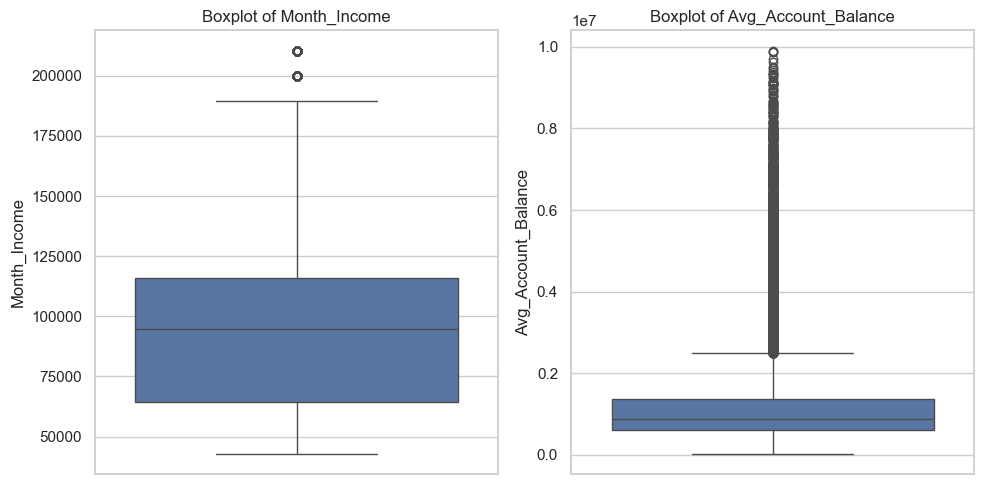

In [112]:
columns_with_outliers = ['Month_Income', 'Avg_Account_Balance']

plt.figure(figsize=(10, 5))

for i, column in enumerate(columns_with_outliers, 1):
    plt.subplot(1, len(columns_with_outliers), i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    
plt.tight_layout()
plt.show()

In [113]:
# Cap outliers in 'Avg_Account_Balance'
# df['Avg_Account_Balance'] = df['Avg_Account_Balance'].clip(lower=-546012.75, upper=2497021.25)

In [114]:
#selecting categorical columns

categorical_cols = df.select_dtypes(include=['object']).columns.to_list()
categorical_cols

['Gender', 'Occupation', 'Loan_Status', 'Account_Category', 'Lead_Outcome']

In [115]:
#selecting numerical columns

numerical_cols = df.select_dtypes(include=['float64','int64']).columns.to_list()
numerical_cols

['Month_Income',
 'Age',
 'Credit_Score',
 'Existing_Credit_Cards',
 'Avg_Account_Balance',
 'Tenure_with_Bank']

In [116]:
for column in categorical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

        Count  Percentage
Gender                   
Male    47376   53.749021
Female  40767   46.250979
----------------------------------------
               Count  Percentage
Occupation                      
Self_Employed  34941   39.641265
Salaried       27649   31.368345
Other          24927   28.280181
Entrepreneur     626    0.710210
----------------------------------------
             Count  Percentage
Loan_Status                   
No           58530   66.403458
Yes          29613   33.596542
----------------------------------------
                         Count  Percentage
Account_Category                          
Savings Account          40986   46.499438
Current Account          22780   25.844367
Senior Citizens Account  22393   25.405307
Investment Account        1984    2.250888
----------------------------------------
              Count  Percentage
Lead_Outcome                   
No            54485   61.814324
Yes           33658   38.185676
------------------------

In [117]:
for column in numerical_cols:
    value_counts = df[column].value_counts()
    
    percentages = (value_counts / len(df)) * 100
    
    print(pd.DataFrame({'Count': value_counts, 'Percentage': percentages}))
    print("-" * 40)

              Count  Percentage
Month_Income                   
107050.0       7872    8.930942
85640.0        7855    8.911655
74935.0        7793    8.841315
42820.0        7789    8.836777
96345.0        7749    8.791396
53525.0        7714    8.751688
64230.0        7713    8.750553
136825.0       2459    2.789785
210500.0       2446    2.775036
126300.0       2441    2.769363
147350.0       2436    2.763691
199975.0       2434    2.761422
189450.0       2417    2.742135
84200.0        2398    2.720579
105250.0       2397    2.719445
73675.0        2395    2.717175
168400.0       2393    2.714906
157875.0       2390    2.711503
178925.0       2377    2.696754
94725.0        2342    2.657046
115775.0       2333    2.646835
----------------------------------------
     Count  Percentage
Age                   
28    5905    6.699341
29    5336    6.053799
27    5228    5.931271
30    4288    4.864822
26    3631    4.119442
..     ...         ...
81     263    0.298379
82     248    0.

Handle the imbalance columns

In [118]:
def categorize_tenure(value):
    if value in [1, 2, 3, 4]:
        return value
    elif value >= 5 and value <10:
        return 5
    elif value >= 10:
        return 10

# Apply the function to create a new column with categorized values
df['Tenure_with_Bank_Categorized'] = df['Tenure_with_Bank'].apply(categorize_tenure)

# Update the original column with the new categorized values
df['Tenure_with_Bank'] = df['Tenure_with_Bank_Categorized']

# Drop the temporary column
df.drop(columns=['Tenure_with_Bank_Categorized'], inplace=True)

print(df['Tenure_with_Bank'].value_counts())

Tenure_with_Bank
5     26251
10    18304
1     10932
3     10912
2     10889
4     10855
Name: count, dtype: int64


In [119]:
def balance_occupation(dataframe):
    dataframe['Occupation'] = dataframe['Occupation'].replace({'Entrepreneur': 'Other'})
    return dataframe

df = balance_occupation(df)
print(df['Occupation'].value_counts())

Occupation
Self_Employed    34941
Salaried         27649
Other            25553
Name: count, dtype: int64


In [120]:
# handling Existing_Credit_Cards
df['Existing_Credit_Cards'] = df['Existing_Credit_Cards'].apply(lambda x: 0 if x == 0 else 1)

print(df['Existing_Credit_Cards'].value_counts())

Existing_Credit_Cards
0    58530
1    29613
Name: count, dtype: int64


In [121]:

# def undersample_existing_credit_cards(dataframe):
#     # Separate the majority and minority classes
#     df_majority = dataframe[dataframe['Existing_Credit_Cards'] == 0]
#     df_minority = dataframe[dataframe['Existing_Credit_Cards'] == 1]
    
#     # Randomly sample from the majority class
#     df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)
    
#     # Combine the undersampled majority class with the minority class
#     undersampled_dataframe = pd.concat([df_majority_undersampled, df_minority])
    
#     # Shuffle the resulting dataset
#     undersampled_dataframe = undersampled_dataframe.sample(frac=1, random_state=42).reset_index(drop=True)
    
#     return undersampled_dataframe

# df = undersample_existing_credit_cards(df)
# print(df['Existing_Credit_Cards'].value_counts())

In [122]:
# # Define Loan_Status as the target to be balanced
# ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# # Resample based on Loan_Status
# X_res, y_res = ros.fit_resample(df.drop('Loan_Status', axis=1), df['Loan_Status'])

# # Combine the resampled target back with the original features
# df_resampled = pd.concat([pd.DataFrame(X_res, columns=df.drop('Loan_Status', axis=1).columns), pd.DataFrame(y_res, columns=['Loan_Status'])], axis=1)

# print(df_resampled['Loan_Status'].value_counts())

Exploratory Data Analysis (EDA)


In [123]:
print("\nStatistical summary of the dataset")
df.describe()


Statistical summary of the dataset


,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Tenure_with_Bank
count,88143.000000,88143.000000,88143.000000,88143.000000,8.814300e+04,88143.000000
mean,100736.196068,42.835710,598.672952,0.335965,1.122263e+06,4.800846
std,45184.678330,14.893035,179.940523,0.472330,8.656068e+05,2.977684
min,42820.000000,24.000000,300.000000,0.000000,2.259700e+04,1.000000
25%,64230.000000,29.000000,441.000000,0.000000,5.951250e+05,3.000000
50%,94725.000000,41.000000,583.000000,0.000000,8.833420e+05,5.000000
75%,115775.000000,53.000000,767.000000,1.000000,1.355884e+06,5.000000
max,210500.000000,85.000000,900.000000,1.000000,9.908858e+06,10.000000


In [124]:
sns.set(style="whitegrid")

# Function to plot distributions
def plot_distribution(column):
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        sns.countplot(x=column, data=df, palette='viridis')
        plt.title(f'Distribution of {column}')
    else:
        sns.histplot( df[column], bins=30, kde=True, color='skyblue')
        plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()


# Function to plot count plot by target
def plot_by_target(column, target_column='Lead_Outcome'):
    plt.figure(figsize=(10, 5))
    if df[column].dtype == 'object':
        sns.countplot(x=column, hue=target_column, data=df, palette='Set2')
        plt.title(f'{column} Distribution by {target_column}')
    else:
        sns.boxplot(x=target_column, y=column, data=df, palette='Set2')
        plt.title(f'{column} Distribution by {target_column}')
    plt.xlabel(column)
    plt.ylabel('Count' if df[column].dtype == 'object' else column)
    plt.show()

Gender

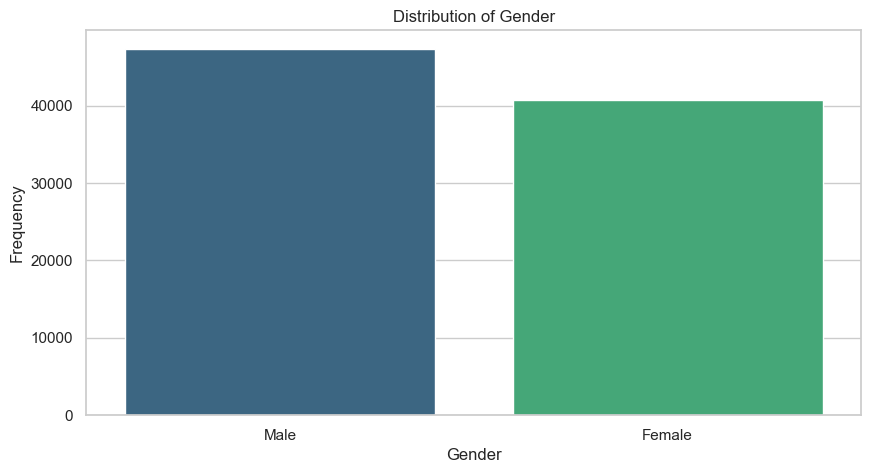

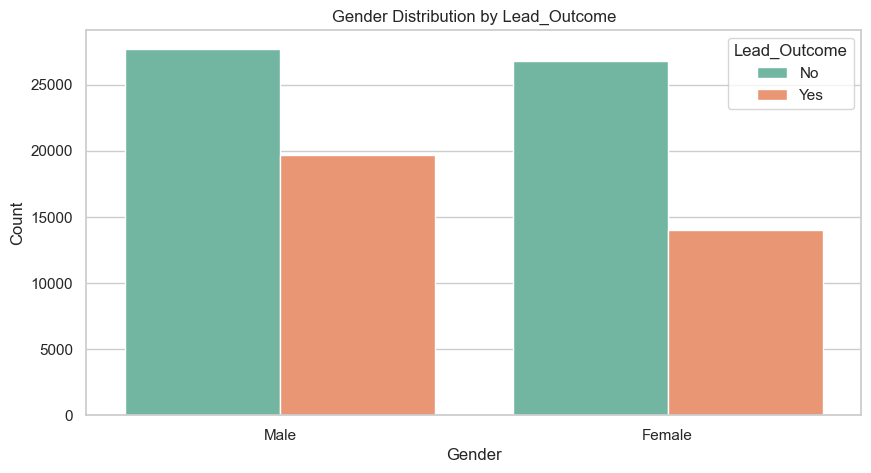

In [125]:
plot_distribution('Gender')
plot_by_target('Gender')

Month_Income

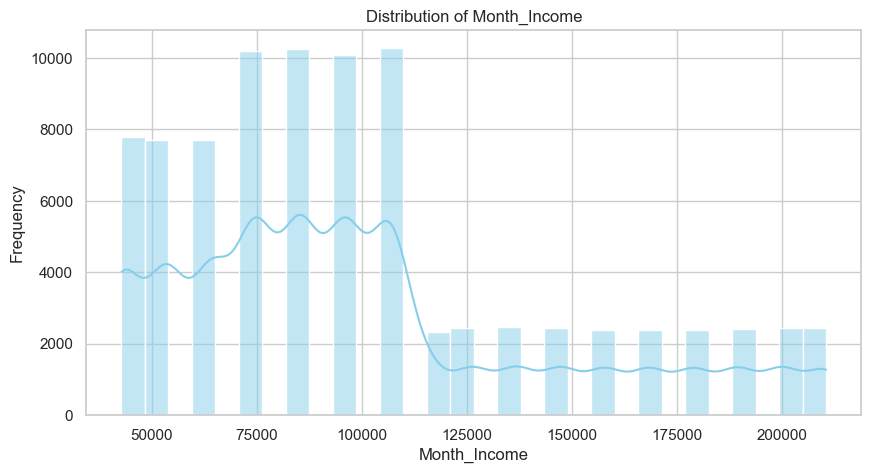

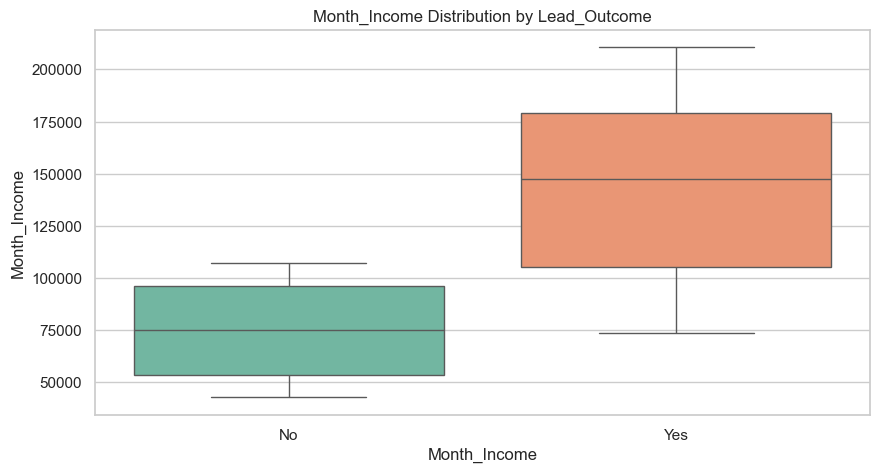

In [126]:
plot_distribution('Month_Income')
plot_by_target('Month_Income')

Age

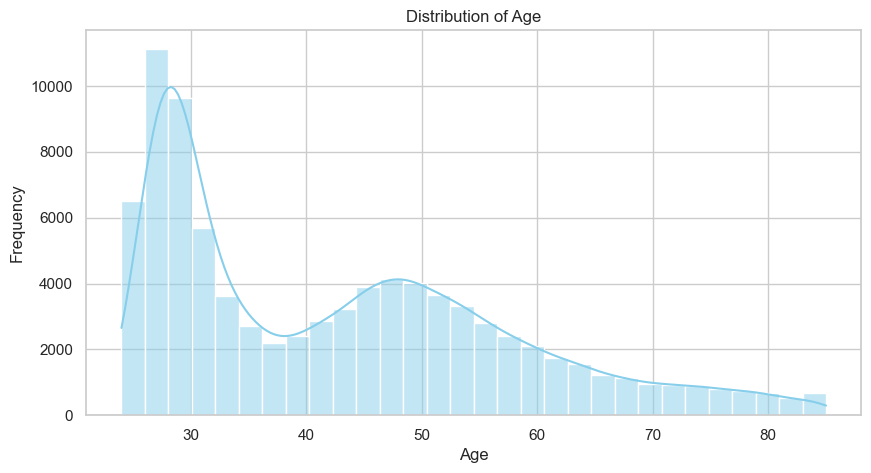

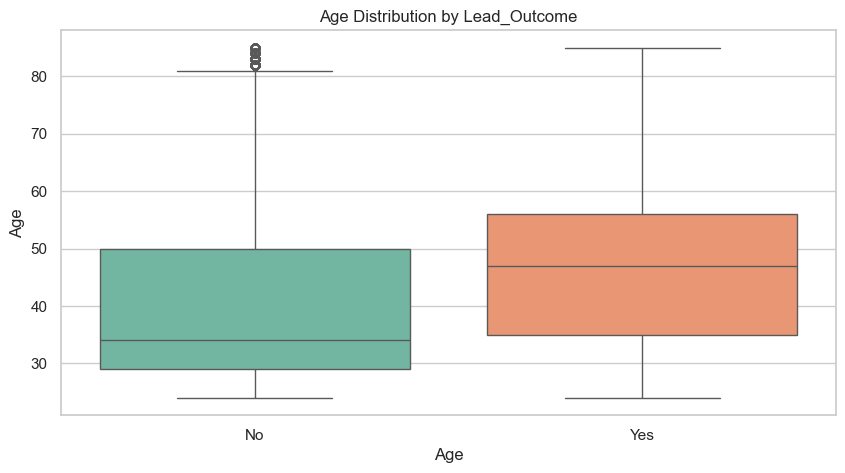

In [127]:
plot_distribution('Age')
plot_by_target('Age')

Occupation

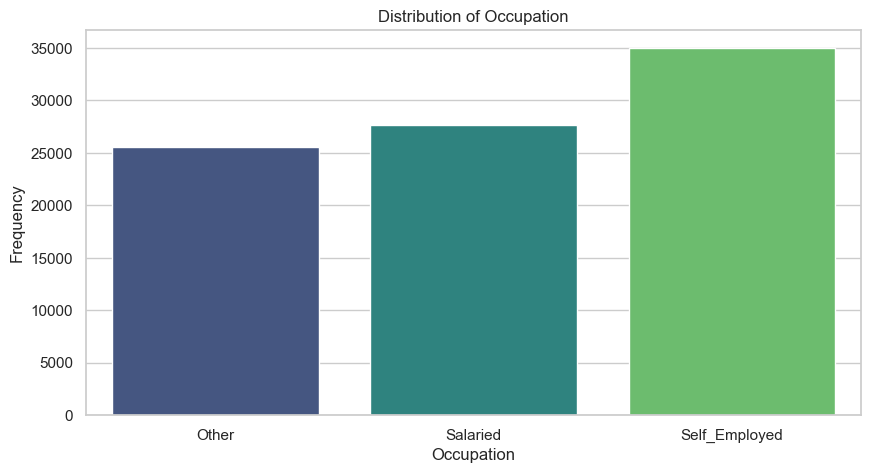

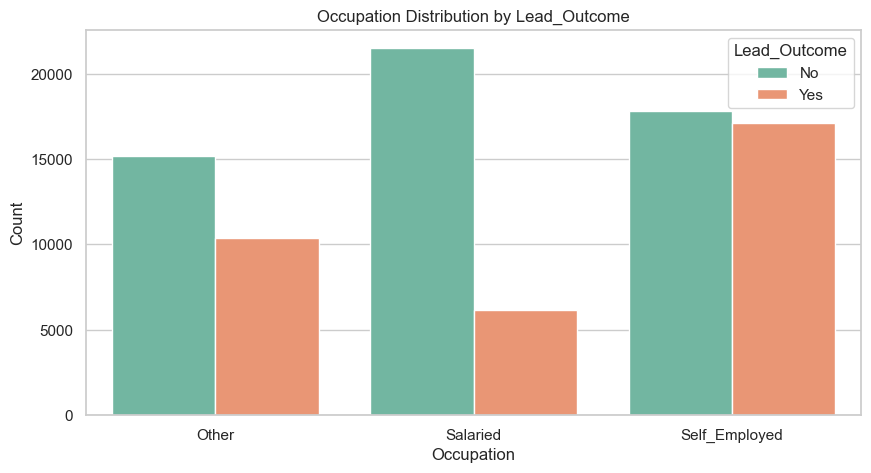

In [128]:
plot_distribution('Occupation')
plot_by_target('Occupation')

Loan_Status

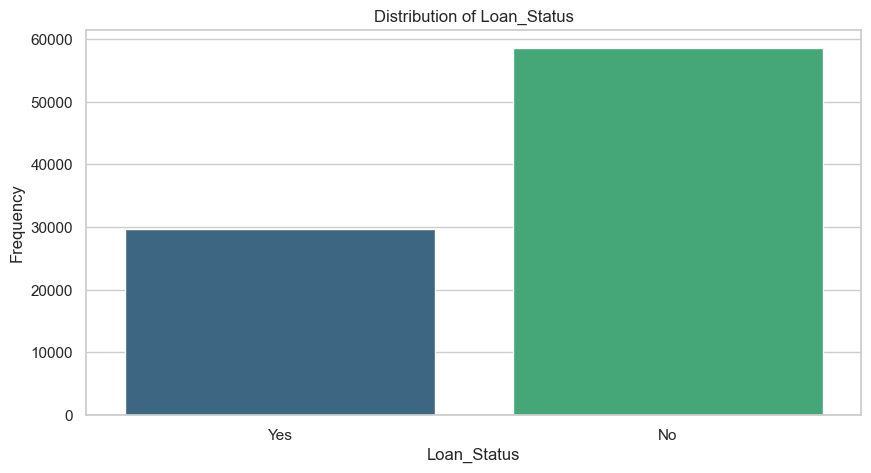

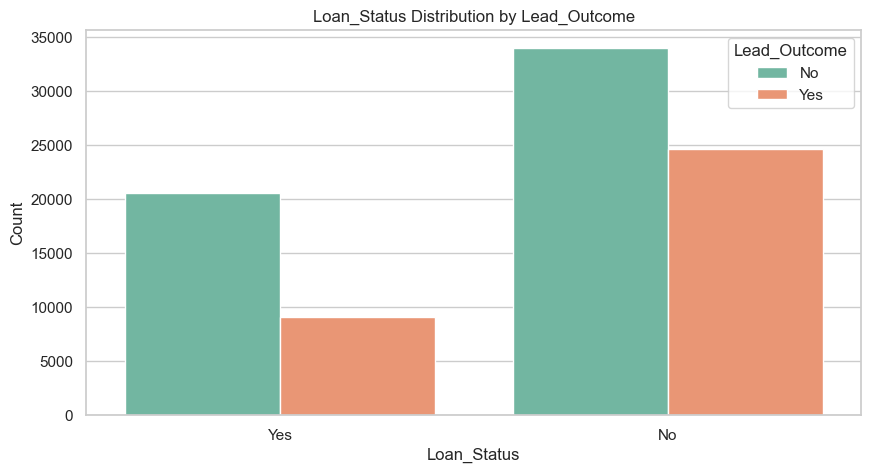

In [129]:
plot_distribution('Loan_Status')
plot_by_target('Loan_Status')

Existing_Credit_Cards

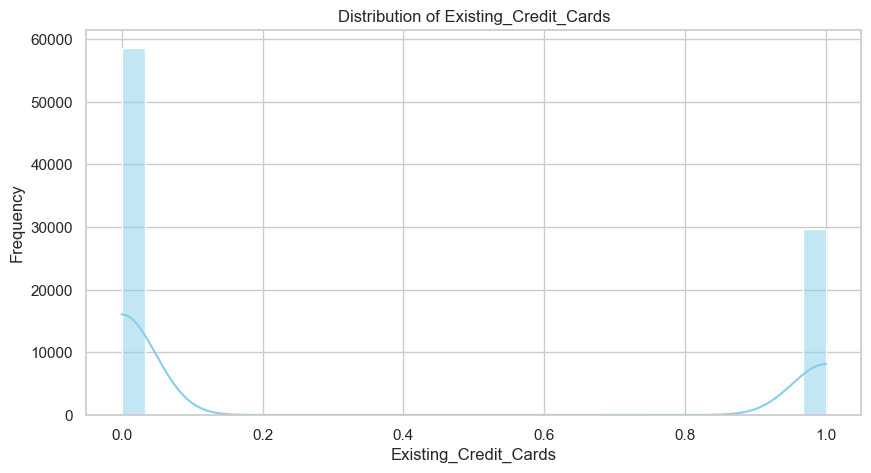

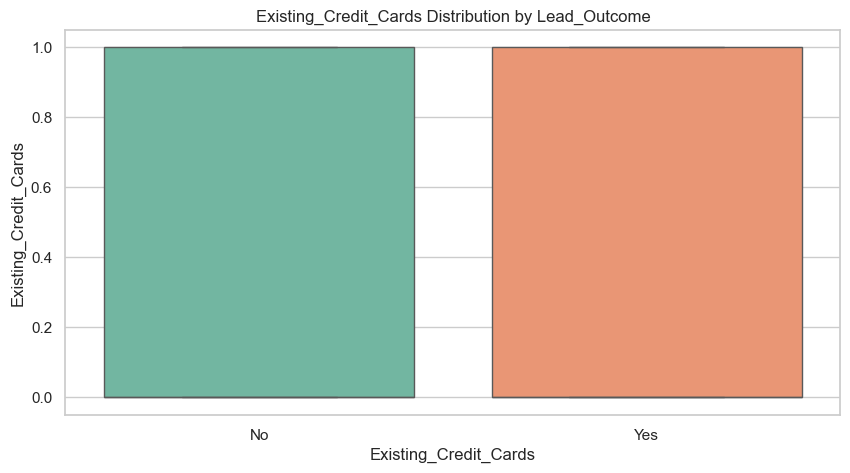

In [130]:
plot_distribution('Existing_Credit_Cards')
plot_by_target('Existing_Credit_Cards')

Account_Category

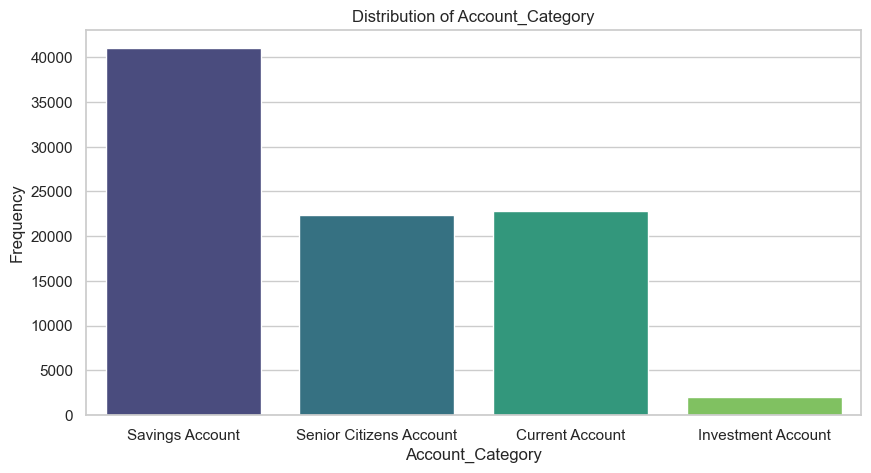

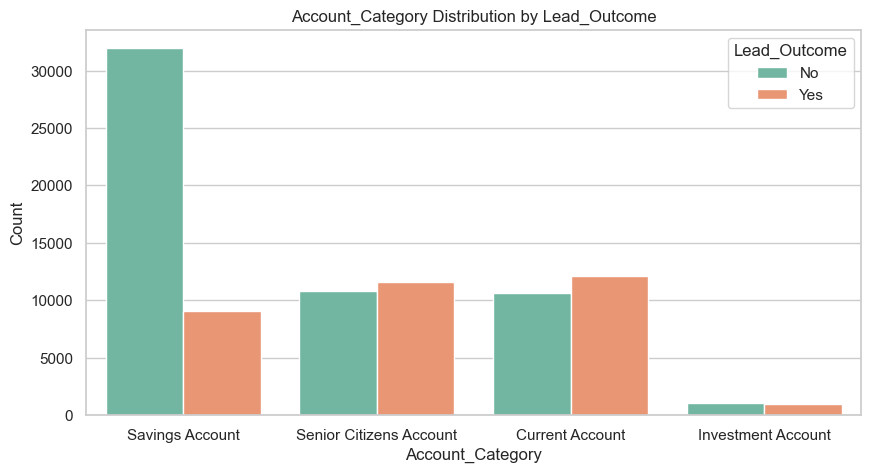

In [131]:
plot_distribution('Account_Category')
plot_by_target('Account_Category')

Tenure_with_Bank

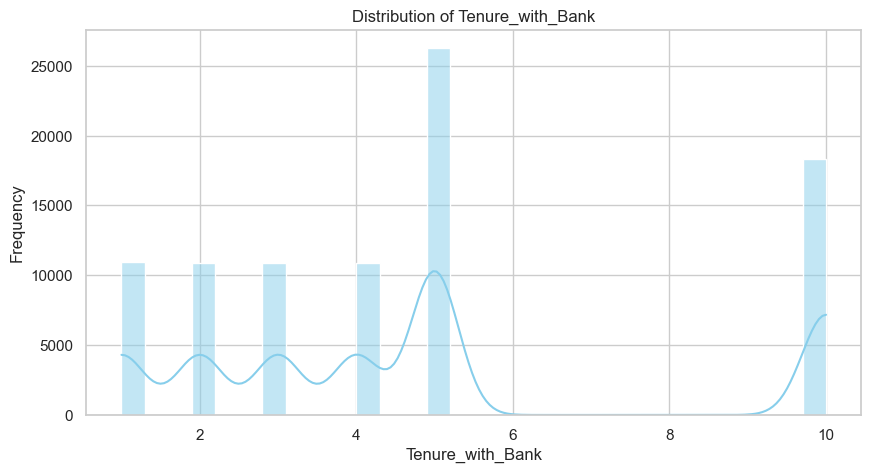

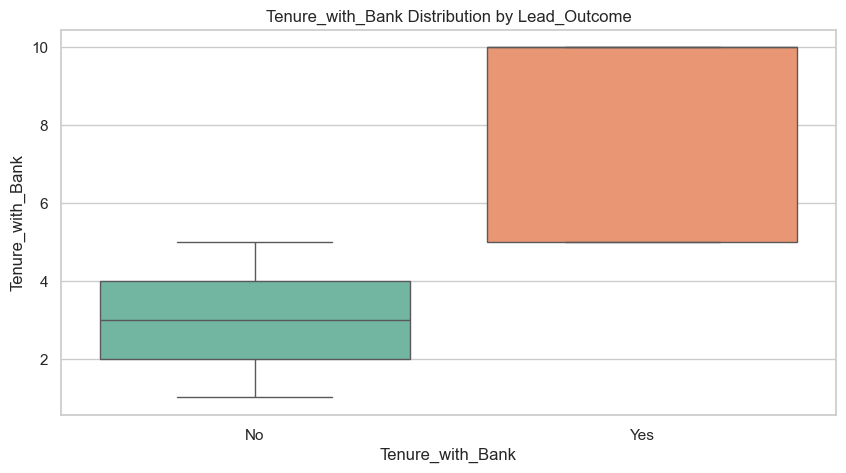

In [132]:
plot_distribution('Tenure_with_Bank')
plot_by_target('Tenure_with_Bank')

Lead_Outcome

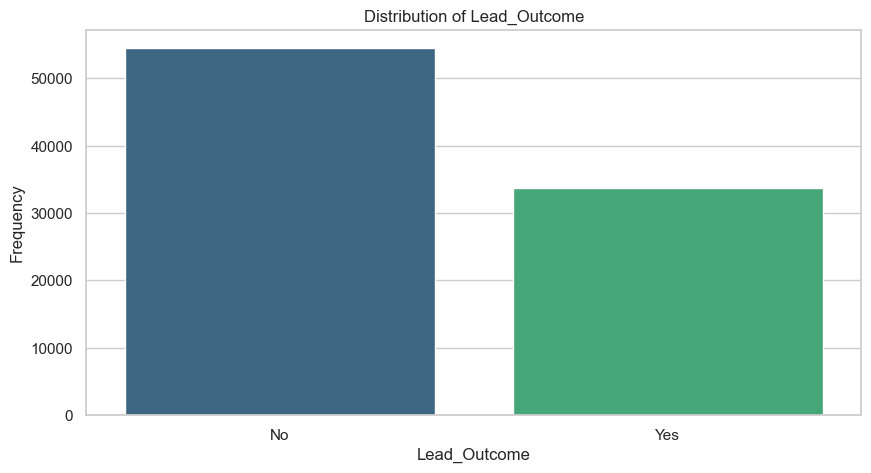

In [133]:
plot_distribution('Lead_Outcome')

Encoding the columns 

In [134]:
# #Convert categorical features into numerical values

# # Initialize the LabelEncoder
# label_encoders = {}
# for col in categorical_cols:
#     label_encoder = LabelEncoder()
#     df[col] = label_encoder.fit_transform(df[col])
#     label_encoders[col] = label_encoder

#     # Display mapping for this column
#     print(f"\nMapping for {col}:")
#     for class_index, class_label in enumerate(label_encoder.classes_):
#         print(f"{class_label}: {class_index}")

df['Lead_Outcome']=df['Lead_Outcome'].apply(lambda x : 1 if x=='Yes' else 0) 
df = pd.get_dummies(df)
print(df.columns)

df.to_csv('../Dataset/processed_training_data.csv', index=False)

Index(['Month_Income', 'Age', 'Credit_Score', 'Existing_Credit_Cards',
       'Avg_Account_Balance', 'Tenure_with_Bank', 'Lead_Outcome',
       'Gender_Female', 'Gender_Male', 'Occupation_Other',
       'Occupation_Salaried', 'Occupation_Self_Employed', 'Loan_Status_No',
       'Loan_Status_Yes', 'Account_Category_Current Account',
       'Account_Category_Investment Account',
       'Account_Category_Savings Account',
       'Account_Category_Senior Citizens Account'],
      dtype='object')


In [135]:
df.head()

,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Tenure_with_Bank,Lead_Outcome,Gender_Female,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Loan_Status_No,Loan_Status_Yes,Account_Category_Current Account,Account_Category_Investment Account,Account_Category_Savings Account,Account_Category_Senior Citizens Account
0,96345.0,29,623,1,742366,2,0,False,True,True,False,False,False,True,False,False,True,False
2,96345.0,31,357,0,215949,1,0,False,True,False,True,False,True,False,False,False,True,False
3,85640.0,29,356,0,868070,3,0,False,True,True,False,False,True,False,False,False,True,False
4,42820.0,29,572,0,657087,3,0,True,False,True,False,False,True,False,False,False,True,False
5,64230.0,60,478,0,4624262,5,0,False,True,False,False,True,True,False,False,False,False,True


Train the model

In [136]:
X = df.drop('Lead_Outcome', axis=1).values  # Features
y = df['Lead_Outcome'].values  # Target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [137]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



In [138]:
# Parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],  # Compatible solvers
    'max_iter': [100, 200, 300],  # Added to explore convergence at different iterations
    'class_weight': ['balanced', None]  # To handle class imbalance
}
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to try
    'weights': ['uniform', 'distance'],  # Uniform or distance-based weights
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'p': [1, 2]  # p=1 (Manhattan), p=2 (Euclidean), only used for 'minkowski' metric
}

# Initialize model
models = {
    'Logistic Regression': (LogisticRegression(), param_grid_lr),
    'KNN':(KNeighborsClassifier(), param_grid_knn),
}

In [139]:
# Perform hyperparameter tuning with K-Fold Cross Validation
best_models = {}

for name, (model, param_grid) in models.items():
    print(f"Starting hyperparameter tuning for {name}...")
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=2)
   
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")

    print('*'*40)
    
    best_models[name] = grid_search.best_estimator_

Starting hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for Logistic Regression: {'C': 10, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score for Logistic Regression: 0.9725931928687197
****************************************
Starting hyperparameter tuning for KNN...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score for KNN: 0.973517017828201
****************************************


In [140]:
# Evaluate the tuned models
def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        print(f'\nPerformance Report for {name} (Tuned):\n')
        
        # Predict the outcomes
        y_pred = model.predict(X_test)
        
        # Compute and print accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.4f}')

        # Compute and print classification report
        print('Classification Report:')
        print(classification_report(y_test, y_pred))

# Call the function to evaluate the best models
evaluate_models(best_models, X_test, y_test)


Performance Report for Logistic Regression (Tuned):

Accuracy: 0.9746
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16358
           1       0.96      0.97      0.97     10085

    accuracy                           0.97     26443
   macro avg       0.97      0.97      0.97     26443
weighted avg       0.97      0.97      0.97     26443


Performance Report for KNN (Tuned):

Accuracy: 0.9779
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     16358
           1       0.99      0.95      0.97     10085

    accuracy                           0.98     26443
   macro avg       0.98      0.97      0.98     26443
weighted avg       0.98      0.98      0.98     26443



Test MAE, MSE, and R² for Logistic Regression and KNN

In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = best_models['Logistic Regression'].predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Logistic Regression Mean Absolute Error: {mae}")
print(f"Logistic Regression Mean Squared Error: {mse}")

print('\n\n')

y_pred = best_models['KNN'].predict(X_test)

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"KNN Mean Absolute Error: {mae}")
print(f"KNN Mean Squared Error: {mse}")

Logistic Regression Mean Absolute Error: 0.025375335627576295
Logistic Regression Mean Squared Error: 0.025375335627576295



KNN Mean Absolute Error: 0.02208523995008131
KNN Mean Squared Error: 0.02208523995008131


In [142]:
train_accuracy = best_models['Logistic Regression'].score(X_train, y_train)
test_accuracy = best_models['Logistic Regression'].score(X_test, y_test)
print(f"Logistic Regression Training Accuracy: {train_accuracy}")
print(f"Logistic Regression Test Accuracy: {test_accuracy}")

print('\n\n')


train_accuracy = best_models['KNN'].score(X_train, y_train)
test_accuracy = best_models['KNN'].score(X_test, y_test)
print(f"KNN Training Accuracy: {train_accuracy}")
print(f"KNN Test Accuracy: {test_accuracy}")


Logistic Regression Training Accuracy: 0.9729173419773096
Logistic Regression Test Accuracy: 0.9746246643724237



KNN Training Accuracy: 1.0
KNN Test Accuracy: 0.9779147600499187


In [143]:
from sklearn.model_selection import cross_val_score

model = best_models['Logistic Regression']
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Logistic Regression Cross-Validation Accuracy: {cv_scores.mean()}")

print('\n\n')

model = best_models['KNN']
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"KNN Cross-Validation Accuracy: {cv_scores.mean()}")


Logistic Regression Cross-Validation Accuracy: 0.9673095623987035



KNN Cross-Validation Accuracy: 0.972998379254457


Save the model


In [144]:
import joblib

# Save the model
joblib.dump(best_models['Logistic Regression'], '../TrainedModels/Logistic_Regression_model.pkl')
joblib.dump(best_models['KNN'], '../TrainedModels/KNN_model.pkl')

['../TrainedModels/KNN_model.pkl']

In [145]:
# Load the model
loaded_model = joblib.load('../TrainedModels/Logistic_Regression_model.pkl')

Make a prediction

In [146]:
# Example new data
new_data = pd.DataFrame({
    'Gender': ['Male'],
    'Month_Income': [200000],
    'Age': [35],
    'Occupation': ['Entrepreneur'],
    'Credit_Score': [350],
    'Loan_Status': ['No'],
    'Existing_Credit_Cards': [2],
    'Avg_Account_Balance': [100000],
    'Account_Category': ['Investment Account'],
    'Tenure_with_Bank': [1]
})

new_data_encoded = pd.get_dummies(new_data)

all_columns = df.columns.drop('Lead_Outcome') 
new_data = new_data_encoded.reindex(columns=all_columns, fill_value=0)


In [147]:
new_data

,Month_Income,Age,Credit_Score,Existing_Credit_Cards,Avg_Account_Balance,Tenure_with_Bank,Gender_Female,Gender_Male,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Loan_Status_No,Loan_Status_Yes,Account_Category_Current Account,Account_Category_Investment Account,Account_Category_Savings Account,Account_Category_Senior Citizens Account
0,200000,35,350,2,100000,1,0,True,0,0,0,True,0,0,True,0,0


In [148]:
# Make predictions
predictions = loaded_model.predict(new_data)

predictions = ['Yes' if pred == 1 else 'No' for pred in predictions]

print(f'Predicted Lead Outcome: {predictions[0]}')


Predicted Lead Outcome: No
